In [ ]:
def get_tree_percent(x):
    return x['geometry_tree'].intersection(x['geometry']).area/x['geometry'].area
#tract_taz['tract_pct'] = tract_taz[['geometry','geometry_taz']].apply(get_percent, axis = 1)


In [ ]:
def ix2xy(r,c,gt):
    '''Gets x,y from row and column'''
    x = gt[0] + r * gt[1]
    y = gt[3] + c * gt[5]
    return(x,y)

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import gdal
import rasterio
import fiona
import rasterio.mask
from rastertodataframe import raster_to_dataframe
import itertools

## Read in Image Data

In [2]:
boundaryDir = r'data\boundaries'
treeDir = r'data\trees'
img = 'delmarnaip.tif'
delmar = gpd.read_file(os.path.join(boundaryDir,"DEL_MAR.shp"))
crs_ref  = rasterio.open(os.path.join('data','images',img)).crs
delmar = delmar.to_crs(crs_ref)

# Read in tree data into correct projection
dmtrees = gpd.read_file(os.path.join(treeDir,'delmar_trees.shp'))
dmtrees = dmtrees.to_crs(delmar.crs)
tree_mask = dmtrees.geometry.unary_union


## Process Raster Data

In [3]:
#crop del mar from image file
shapes = delmar['geometry']
with rasterio.open(os.path.join('data','images',img)) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [4]:
#save del mar raster
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(os.path.join('data','images',"delmar_masked_naip.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

In [5]:
#tree mask
dmt = rasterio.open(os.path.join('data','images','delmar_masked_naip.tif'))
# crop trees and 'not' trees
out_image_trees, out_transform_trees = rasterio.mask.mask(dmt, tree_mask, crop=True, invert = False)
out_meta_trees = dmt.meta
out_image_not_trees, out_transform_not_trees = rasterio.mask.mask(dmt, tree_mask, crop=False, invert = True)
out_meta_not_trees = dmt.meta

out_meta_trees.update({"driver": "GTiff",
                 "height": out_image_trees.shape[1],
                 "width": out_image_trees.shape[2],
                 "transform": out_transform_trees})

with rasterio.open(os.path.join('data','images',"delmar_masked_trees_naip.tif"), "w", **out_meta_trees) as dest:
    dest.write(out_image_trees)
    
    
out_meta_not_trees.update({"driver": "GTiff",
                 "height": out_image_not_trees.shape[1],
                 "width": out_image_not_trees.shape[2],
                 "transform": out_transform_not_trees})

with rasterio.open(os.path.join('data','images',"delmar_masked_not_trees_naip.tif"), "w", **out_meta_not_trees) as dest:
    dest.write(out_image_not_trees)

# Load Training Data

In [6]:
#ds = gdal.Open(os.path.join('data','images','delmar_masked.tif'))
#gt = ds.GetGeoTransform()


#df = pd.DataFrame.from_records(itertools.product(range(ds.RasterYSize),range(ds.RasterXSize)),columns=['Row','Column'])

#ds = None

#df['X'], df['Y'] = zip(*df.apply(lambda x: ix2xy(x['Column'],x['Row'],gt),axis=1))

In [7]:
# Load Trees to DataFrame
dmtgrtree = raster_to_dataframe(os.path.join('data','images','delmar_masked_trees_naip.tif'))
dmtgrtree['tree'] = 1

In [8]:
# Load Not Trees to DataFrame
dmtgrntree = raster_to_dataframe(os.path.join('data','images','delmar_masked_not_trees_naip.tif'))
dmtgrntree['tree'] = 0

In [55]:
# clip no data values
dmtgrtree['summy'] = dmtgrtree.Band_1+dmtgrtree.Band_2+dmtgrtree.Band_3+dmtgrtree.Band_4
dmtgrntree['summy'] = dmtgrntree.Band_1+dmtgrntree.Band_2+dmtgrntree.Band_3+dmtgrntree.Band_4
tree_training = pd.concat([dmtgrtree[dmtgrtree.summy >0],dmtgrntree[dmtgrntree.summy > 0]], axis = 0)
tree_training = tree_training[['Band_1','Band_2','Band_3','Band_4','tree']].rename(columns = {'Band_1':'R','Band_2':'G','Band_3':'B','Band_4':'I'})

In [56]:
# Calculate Ratios
bands = ['R','G','B','I']
for b in bands:
    for r in bands:
        if b==r: continue
        tree_training['{}_{}'.format(b,r)] = tree_training[b]/tree_training[r]

In [57]:
# Check Correlations
tree_training = tree_training.replace([np.inf, -np.inf], np.nan)
tree_training = tree_training.fillna(0)
tree_training.corr(method = 'kendall')

,R,G,B,I,tree,R_G,R_B,R_I,G_R,G_B,G_I,B_R,B_G,B_I,I_R,I_G,I_B
R,1.000000,0.848862,0.798553,0.290181,-0.314179,0.201518,-0.053376,0.256868,-0.201518,-0.235206,0.272149,0.053376,0.235206,0.270740,-0.256868,-0.272149,-0.270740
G,0.848862,1.000000,0.825509,0.293218,-0.303766,0.045114,-0.131273,0.232093,-0.045114,-0.214286,0.296715,0.131273,0.214286,0.281410,-0.232093,-0.296715,-0.281410
B,0.798553,0.825509,1.000000,0.156994,-0.337094,0.076732,-0.260212,0.356983,-0.076732,-0.394425,0.407575,0.260212,0.394425,0.431978,-0.356983,-0.407575,-0.431978
I,0.290181,0.293218,0.156994,1.000000,0.044312,-0.102044,0.218997,-0.456661,0.102044,0.308079,-0.413939,-0.218997,-0.308079,-0.414625,0.456661,0.413939,0.414625
tree,-0.314179,-0.303766,-0.337094,0.044312,1.000000,-0.150413,0.086570,-0.336824,0.150413,0.200821,-0.334114,-0.086570,-0.200821,-0.321614,0.336824,0.334114,0.321614
R_G,0.201518,0.045114,0.076732,-0.102044,-0.150413,1.000000,0.340306,0.164442,-1.000000,-0.088288,0.030762,-0.340306,0.088288,0.040459,-0.164442,-0.030762,-0.040459
R_B,-0.053376,-0.131273,-0.260212,0.218997,0.086570,0.340306,1.000000,-0.290692,-0.340306,0.572238,-0.381588,-1.000000,-0.572238,-0.460209,0.290692,0.381588,0.460209
R_I,0.256868,0.232093,0.356983,-0.456661,-0.336824,0.164442,-0.290692,1.000000,-0.164442,-0.485707,0.866608,0.290692,0.485707,0.830706,-1.000000,-0.866608,-0.830706
G_R,-0.201518,-0.045114,-0.076732,0.102044,0.150413,-1.000000,-0.340306,-0.164442,1.000000,0.088288,-0.030762,0.340306,-0.088288,-0.040459,0.164442,0.030762,0.040459
G_B,-0.235206,-0.214286,-0.394425,0.308079,0.200821,-0.088288,0.572238,-0.485707,0.088288,1.000000,-0.489936,-0.572238,-1.000000,-0.608605,0.485707,0.489936,0.608605


In [58]:
tree_training.corr(method = 'kendall').to_csv('naip_corr.csv')

# Load Model

In [12]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [39]:
X = tree_training[['Band_1','Band_2','Band_3','Band_2_Band_3','Band_2_Band_1']]
y = tree_training.tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [40]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.411341
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.178       
Dependent Variable: tree             AIC:              3786502.3266
Date:               2020-05-04 12:49 BIC:              3786569.0373
No. Observations:   4602623          Log-Likelihood:   -1.8932e+06 
Df Model:           4                LL-Null:          -2.3029e+06 
Df Residuals:       4602618          LLR p-value:      0.0000      
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     7.0000                                         
--------------------------------------------------------------------
                Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Band_1         -0.0116    0.0001  -80.3315  0.0000  -0.0119  -0.0113
Band_2          0.0020    0.0002   13

In [41]:
logreg = LogisticRegression(random_state=0,max_iter=200)
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


In [52]:
y_pred.sum()


75954

In [53]:
y_test.sum()



275785

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[1076256   28746]
 [ 228577   47208]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89   1105002
           1       0.62      0.17      0.27    275785

    accuracy                           0.81   1380787
   macro avg       0.72      0.57      0.58   1380787
weighted avg       0.78      0.81      0.77   1380787



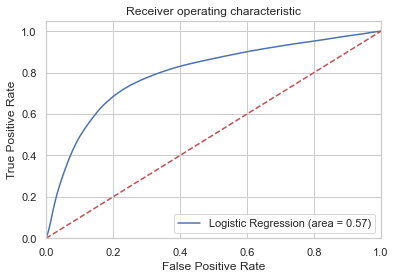

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_naip')
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[1076256   28746]
 [ 228577   47208]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89   1105002
           1       0.62      0.17      0.27    275785

    accuracy                           0.81   1380787
   macro avg       0.72      0.57      0.58   1380787
weighted avg       0.78      0.81      0.77   1380787



In [46]:
#import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(ge_data.tree, logreg.predict(ge_data[['Band_1','Band_2','Band_3','Band_3_Band_2']]))
# fpr, tpr, thresholds = roc_curve(ge_data.tree, logreg.predict_proba(ge_data[['Band_1','Band_2','Band_3','Band_3_Band_2']])[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC_naip_on_ge')
# plt.show()

In [35]:
tree_training.tree.sum()/len(tree_training)

0.19995163627349014

In [47]:
predict = logreg.predict(X)
predict.sum()/len(predict)

0.05504339590707299

In [60]:
logreg.predict(X_test).sum()/len(logreg.predict(X_test))

0.05500776006726599

In [62]:
y_test.sum()/len(y_test)

0.19973029873543133

In [37]:
tree_training.to_csv('naip_training.csv')

In [24]:
len(predict)

4602623

In [25]:
#ge_data = pd.read_csv('google_earth_tree_training.csv')

In [26]:
#logreg.score(ge_data[['Band_1','Band_2','Band_3','Band_3_Band_2']],ge_data.tree)

In [ ]:
tree_mask.area

In [ ]:
tree_mask.area/delmar.iloc[0].geometry.area


In [49]:
#nt = pd.read_csv('hro_training.csv')
predict = logreg.predict(nt[['Band_1','Band_2','Band_3','Band_2_Band_3','Band_2_Band_1']])
predict.sum()/len(predict)

0.0

In [50]:
nt = pd.read_csv('ge_training.csv')
predict = logreg.predict(nt[['Band_1','Band_2','Band_3','Band_2_Band_3','Band_2_Band_1']])
predict.sum()/len(predict)

0.07521922607870846

In [51]:
nt = pd.read_csv('hro_training.csv')
predict = logreg.predict(nt[['Band_1','Band_2','Band_3','Band_2_Band_3','Band_2_Band_1']])
predict.sum()/len(predict)

0.0

## Test On 2016

In [ ]:
boundaryDir = r'data\boundaries'
treeDir = r'data\trees'
img = 'delmarNAIP_2016.tif'
delmar = gpd.read_file(os.path.join(boundaryDir,"DEL_MAR.shp"))
crs_ref  = rasterio.open(os.path.join('data','images',img)).crs
delmar = delmar.to_crs(crs_ref)

# Read in tree data into correct projection
dmtrees = gpd.read_file(os.path.join(treeDir,'delmar_trees.shp'))
dmtrees = dmtrees.to_crs(delmar.crs)
tree_mask = dmtrees.geometry.unary_union


In [ ]:
#crop del mar from image file
shapes = delmar['geometry']
with rasterio.open(os.path.join('data','images',img)) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [ ]:
#save del mar raster
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(os.path.join('data','images',"delmar_masked_naip.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
#tree mask
dmt = rasterio.open(os.path.join('data','images','delmar_masked_naip_2016.tif'))
# crop trees and 'not' trees
out_image_trees, out_transform_trees = rasterio.mask.mask(dmt, tree_mask, crop=True, invert = False)
out_meta_trees = dmt.meta
out_image_not_trees, out_transform_not_trees = rasterio.mask.mask(dmt, tree_mask, crop=False, invert = True)
out_meta_not_trees = dmt.meta

out_meta_trees.update({"driver": "GTiff",
                 "height": out_image_trees.shape[1],
                 "width": out_image_trees.shape[2],
                 "transform": out_transform_trees})

with rasterio.open(os.path.join('data','images',"delmar_masked_trees_naip_2016.tif"), "w", **out_meta_trees) as dest:
    dest.write(out_image_trees)
    
    
out_meta_not_trees.update({"driver": "GTiff",
                 "height": out_image_not_trees.shape[1],
                 "width": out_image_not_trees.shape[2],
                 "transform": out_transform_not_trees})

with rasterio.open(os.path.join('data','images',"delmar_masked_not_trees_naip_2016.tif"), "w", **out_meta_not_trees) as dest:
    dest.write(out_image_not_trees)